In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization
from models import yolov3
from IPython.core.display import display, HTML
from utils import to_minmax, iou_calculate, non_max_suppression, detections_center_to_minmax
from utils import convert_to_original_size, load_coco_names
from PIL import ImageDraw, Image

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "9"
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)
display(HTML("<style>.container { width:98% !important;}</style>"))

In [3]:
# load image
img = tf.io.read_file("example/000000218362.jpg")
img = tf.image.decode_jpeg(img)
img_resized = tf.image.resize(img,(416, 416))
img_predict = tf.expand_dims(img_resized/255., axis=0)

In [4]:
# Build Model
yolov3_model = yolov3.Darknet_yolo()
yolov3.load_weights("weights/yolov3.weights", yolov3_model)

model_output_1, model_output_2, model_output_3 = yolov3_model(img_predict)

ANCHORS = [(10, 13), (16, 30), (33, 23), (30, 61), (62, 45), (59, 119), (116, 90), (159, 198), (373, 326)]

predictions_1 = yolov3.detection_layer(model_output_1, (416, 416), ANCHORS[6:9], num_classes=80)
predictions_2 = yolov3.detection_layer(model_output_2, (416, 416), ANCHORS[3:6], num_classes=80)
predictions_3 = yolov3.detection_layer(model_output_3, (416, 416), ANCHORS[0:3], num_classes=80)

tf.Tensor(
[[116.  90.]
 [159. 198.]
 [373. 326.]
 ...
 [116.  90.]
 [159. 198.]
 [373. 326.]], shape=(507, 2), dtype=float32)
tf.Tensor(
[[ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 ...
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]], shape=(2028, 2), dtype=float32)
tf.Tensor(
[[10. 13.]
 [16. 30.]
 [33. 23.]
 ...
 [10. 13.]
 [16. 30.]
 [33. 23.]], shape=(8112, 2), dtype=float32)


In [5]:
detections = tf.concat([predictions_1, predictions_2, predictions_3], axis=1)

boxes = detections_center_to_minmax(detections)

conf_threshold = 0.5
iou_threshold = 0.4
class_names = "data/COCO_2017/coco.names"

filtered_boxes = non_max_suppression(boxes, confidence_threshold=conf_threshold, iou_threshold=iou_threshold)

classes = load_coco_names(class_names)

shape1 (10647, 85)
shape2 (10, 85)


In [5]:
img = img_predict.numpy()[0]
img = img * 255
img = img.astype(np.uint8)

In [6]:
for cls, bboxs in filtered_boxes.items():
    for a, b in bboxs:
        x_min, y_min, x_max, y_max = a
        cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        cv2.rectangle(img, (int(x_min)-1, int(y_min)-15), (int(x_max)+1, int(y_min)), (0, 255, 0), -1)
        cv2.putText(img, "Clock", (int(x_min), int(y_min)), cv2.FONT_HERSHEY_COMPLEX, 0.5, [0, 0, 0], 1)
        print((int(x_min), int(y_min)), (int(x_max), int(y_max)))
    #cv2.rectangle(img, (20, 60), (120, 160), (0, 255, 0), 2)

(272, 45) (316, 152)
(325, 81) (356, 164)
(367, 102) (412, 209)
(187, 2) (246, 117)
(57, 0) (170, 74)
(104, 267) (237, 418)


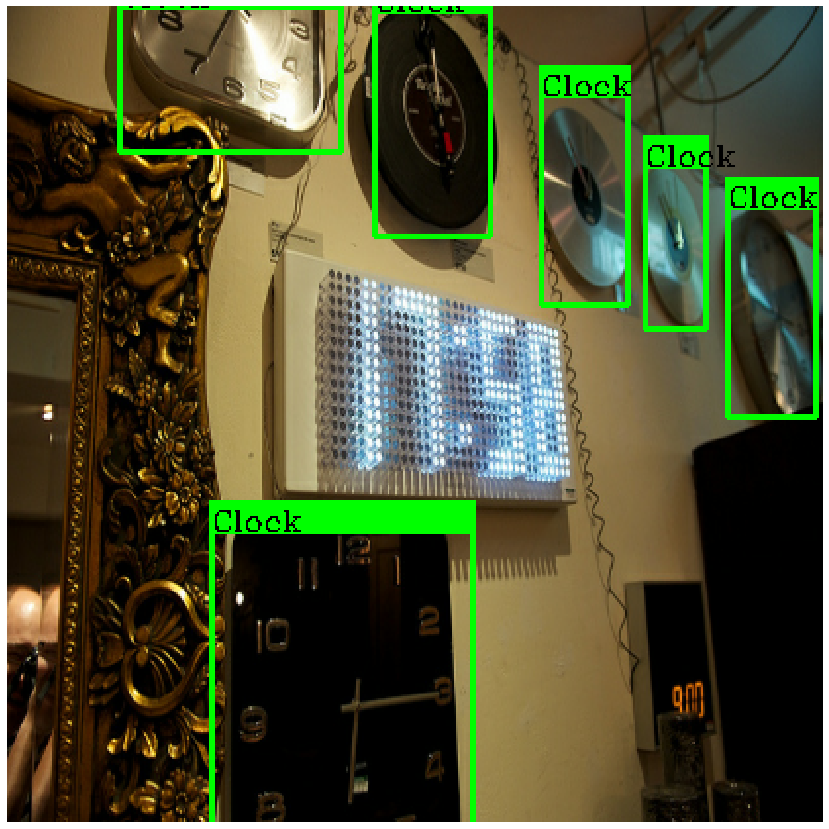

In [7]:
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(img)

In [ ]:
def draw_boxes(boxes, img, cls_names, detections_size):
    draw = ImageDraw.Draw(img)
    
    for cls, bboxs in boxes.items():
        color = tuple(np.random.randint(0, 256, 3))
        for box, score in bboxs:
            box = convert_to_original_size(box, np.array(detections_size), np.array(img.size))
            draw.rectangle(box, outline=color)
            draw.text(box[:2], "{} {:.2f}%".format(cls_names[cls], score * 100), fill=color)
            print("{} {:.2f}%".format(cls_names[cls], score * 100), box[:2])

In [ ]:
draw_boxes(filtered_boxes, img, classes, (416, 416))

img.save(opt.output)